In [ ]:
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

     |████████████████████████████████| 182 kB 4.9 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 1.6 MB 60.6 MB/s 


# Load Data + Preprocess: COCO

In [ ]:
class CocoDataset(Dataset):
    def __init__(self, root, annotation, new_size=(600, 600)):
        self.root = root
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transforms = T.Compose([
            T.ToTensor(),
            torchvision.transforms.Resize(new_size, interpolation=InterpolationMode.BILINEAR)
        ])
        self.new_size = new_size
    
    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(img_id)
        coco_annotation = self.coco.loadAnns(ann_ids)
        path = self.coco.loadImgs(img_id)[0]['file_name']
        
        cv_img = cv2.imread(os.path.join(self.root, path))
        
        torch_img = Image.open(os.path.join(self.root, path))
        orig_size = torch_img.size
        torch_img = self.transforms(torch_img)

        x_scale, y_scale = self.new_size[0] / orig_size[0], self.new_size[1] / orig_size[1]

        num_objects = len(coco_annotation)
        boxes = []
        labels = []
        for i in range(num_objects):
            x = x_scale * coco_annotation[i]['bbox'][0]
            y = y_scale * coco_annotation[i]['bbox'][1]
            h = x_scale * coco_annotation[i]['bbox'][2]
            w = y_scale * coco_annotation[i]['bbox'][3]
            boxes.append([x, y, h, w])

            labels.append(coco_annotation[i]['category_id'])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int)

        img_id = torch.tensor([img_id])
        
        my_annotation = {
            "id": img_id,
            "bbox": boxes,
            "category_id": labels
        }

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [ ]:
dataset_path = "./Datasets/ASL-coco"
ann_file = "_annotations.coco.json"
asl_train_ds = CocoDataset(f"{dataset_path}/train", f"{dataset_path}/train/{ann_file}")
asl_test_ds = CocoDataset(f"{dataset_path}/test", f"{dataset_path}/test/{ann_file}")
asl_val_ds = CocoDataset(f"{dataset_path}/valid", f"{dataset_path}/valid/{ann_file}")

loading annotations into memory...
Done (t=7.46s)
creating index...
index created!
loading annotations into memory...
Done (t=0.85s)
creating index...
index created!
loading annotations into memory...
Done (t=1.13s)
creating index...
index created!


In [ ]:
train_dataloader = torch.utils.data.DataLoader(asl_train_ds, batch_size = 32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(asl_val_ds, batch_size = 32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(asl_test_ds, batch_size = 32, shuffle=False)

##Visualize Data

In [ ]:
%matplotlib inline 

#Test Dataloader
for image, label in train_dataloader:
    img = image
    lab = label
    break

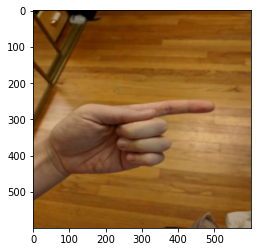

In [ ]:
plt.imshow(img[0].permute(1, 2, 0))

In [ ]:
label_map = asl_test_ds.coco.cats
label_map

{0: {'id': 0, 'name': 'Letters', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'A', 'supercategory': 'Letters'},
 2: {'id': 2, 'name': 'B', 'supercategory': 'Letters'},
 3: {'id': 3, 'name': 'C', 'supercategory': 'Letters'},
 4: {'id': 4, 'name': 'D', 'supercategory': 'Letters'},
 5: {'id': 5, 'name': 'E', 'supercategory': 'Letters'},
 6: {'id': 6, 'name': 'F', 'supercategory': 'Letters'},
 7: {'id': 7, 'name': 'G', 'supercategory': 'Letters'},
 8: {'id': 8, 'name': 'H', 'supercategory': 'Letters'},
 9: {'id': 9, 'name': 'I', 'supercategory': 'Letters'},
 10: {'id': 10, 'name': 'J', 'supercategory': 'Letters'},
 11: {'id': 11, 'name': 'K', 'supercategory': 'Letters'},
 12: {'id': 12, 'name': 'L', 'supercategory': 'Letters'},
 13: {'id': 13, 'name': 'M', 'supercategory': 'Letters'},
 14: {'id': 14, 'name': 'N', 'supercategory': 'Letters'},
 15: {'id': 15, 'name': 'O', 'supercategory': 'Letters'},
 16: {'id': 16, 'name': 'P', 'supercategory': 'Letters'},
 17: {'id': 17, 'name': 'Q', 's

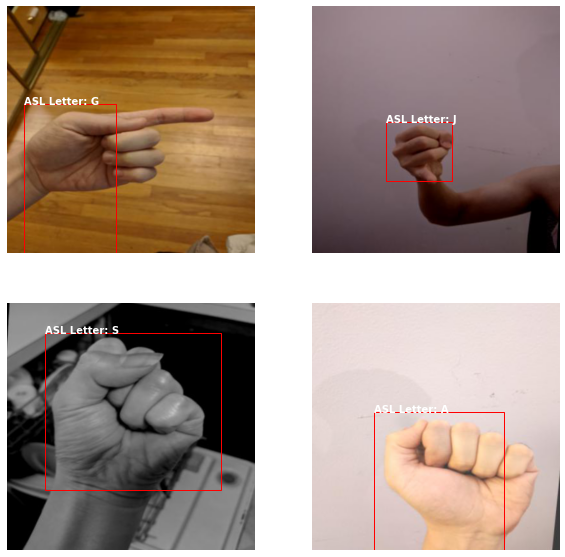

In [ ]:
# Coco: x,y,x_max, y_max
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
count = 0
for i in range(2):
    for j in range(2):
        ax[i][j].axis('off')
        image = img[count]
        box_label = label['bbox'][count][0]
        cat_label = label['category_id'][count]

        ax[i][j].imshow(image.permute(1, 2, 0))

        x, y, h, w = box_label.tolist()
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r',  facecolor='none')
        ax[i][j].add_patch(rect)

        asl_letter = label_map[lab['category_id'][count].item()]['name']
        ax[i][j].text(x, y, f"ASL Letter: {asl_letter}", color='white', fontweight='bold')

        count += 1

plt.show()

In [ ]:
label['bbox'][0][0]

tensor([ 39.6825, 238.0952, 474.3180, 223.8095])

#Human Pose Estimation

In [ ]:
hpe_model = torchvision.models.detection.keypointrcnn_resnet50_fpn(weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT)
hpe_model.eval()

In [ ]:
#Example image
from torchvision.transforms.functional import convert_image_dtype

image_tensor = torchvision.io.read_image(USER_PATH + "/Datasets/HPE-Evaluations/signing-1.jpg")
float_image = convert_image_dtype(image_tensor, dtype=torch.float)

(-0.5, 449.5, 298.5, -0.5)

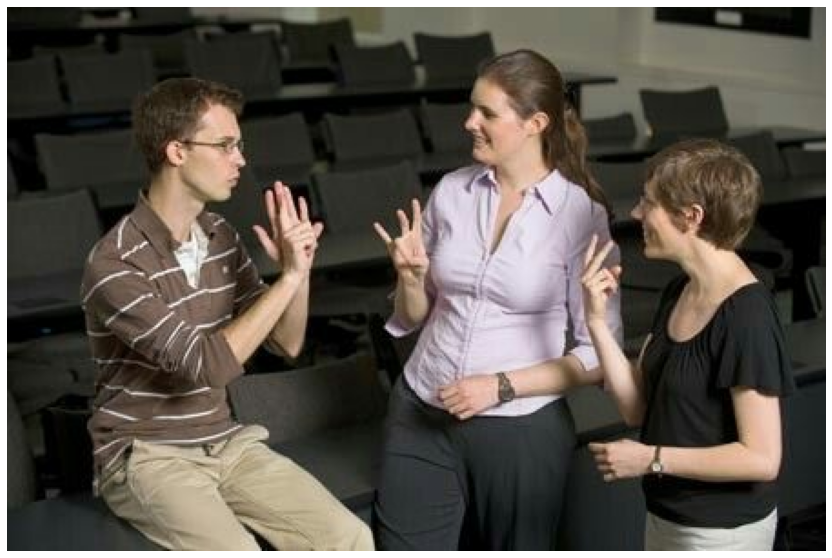

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(float_image.permute(1, 2, 0))
plt.axis('off')

In [ ]:
output = hpe_model([float_image])

In [ ]:
output[0].keys()

dict_keys(['boxes', 'labels', 'scores', 'keypoints', 'keypoints_scores'])

In [ ]:
output[0]['scores'].shape

torch.Size([7])

In [ ]:
kpts = output[0]['keypoints']
scores = output[0]['scores']

kpts = kpts[scores > .75]

# print(kpts)
# print(scores)
print(kpts.shape)

torch.Size([3, 17, 3])


In [ ]:
keypoint_map = [
    "nose", "left_eye", "right_eye", "left_ear", "right_ear",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_hip", "right_hip",
    "left_knee", "right_knee", "left_ankle", "right_ankle",
]

In [ ]:
asl_mechanics_map = torch.zeros(17)
key_point_arr = np.array(keypoint_map)

#"left_shoulder", "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist"
for i in range(5, 11):
    asl_mechanics_map[i] = 1
asl_mechanics_map = asl_mechanics_map.bool()

In [ ]:
kpts.shape

torch.Size([3, 17, 3])

In [ ]:
kpts = kpts[:, asl_mechanics_map]

In [ ]:
kpts.shape

torch.Size([3, 6, 3])

In [ ]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(20, 20))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
#"left_shoulder", "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist"
connect_skeleton = [(0, 2), (2, 4), (1, 3), (3, 5)]

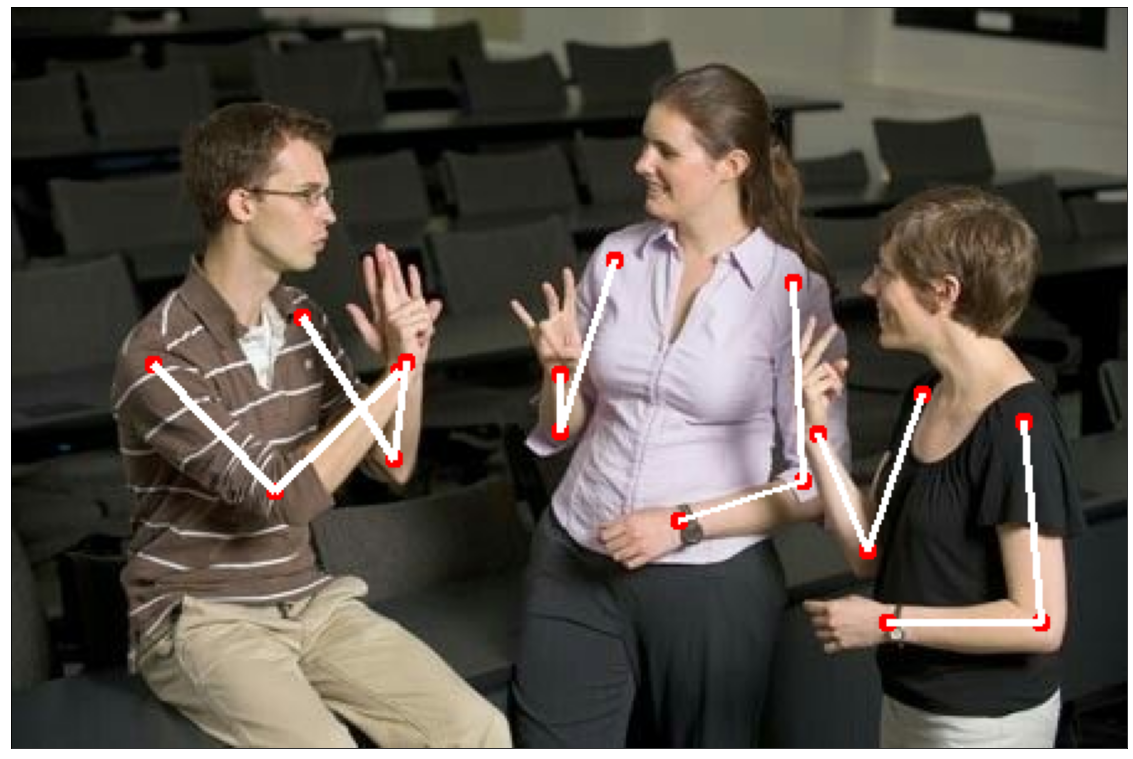

In [ ]:
res = draw_keypoints(image_tensor, kpts, colors="red", connectivity=connect_skeleton, radius=3, width=3)
show(res)

In [ ]:
#"left_shoulder", "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist"
keypoints = kpts[0]

In [ ]:
print(keypoints)
keypoints.shape

tensor([[315.2874, 111.7773,   1.0000],
        [243.5728, 102.0580,   1.0000],
        [319.7695, 191.4014,   1.0000],
        [221.9090, 171.9626,   1.0000],
        [269.7187, 207.8495,   1.0000],
        [221.9090, 148.0381,   1.0000]], grad_fn=<SelectBackward0>)


torch.Size([6, 3])

build threshold for sign

In [ ]:
def threshold_for_signing(keypoints):
    left_elbow = keypoints[2]
    right_elbow = keypoints[3]
    left_wrist = keypoints[4]
    right_wrist = keypoints[5]
    
    is_left_arm_signing = left_elbow[1] > left_wrist[1]
    is_right_arm_signing = right_elbow[1] > right_wrist[1]

    return is_left_arm_signing | is_right_arm_signing

In [ ]:
is_signing = threshold_for_signing(keypoints).item()
is_signing

True

In [ ]:
keypoints.shape

torch.Size([6, 3])

In [ ]:
if is_signing: #Crop and interpolate to write
    keypoints[:, ]

In [ ]:
keypoints[[0, 1], :]

tensor([[315.2874, 111.7773,   1.0000],
        [243.5728, 102.0580,   1.0000]], grad_fn=<IndexBackward0>)

Testing for threshold

#ASL Detection - YOLO

## Load Data + Preprocess: YOLO data


Source: [Fine-tuning Faster-RCNN using pytorch](https://www.kaggle.com/code/yerramvarun/fine-tuning-faster-rcnn-using-pytorch)

In [ ]:
class BB_model(nn.Module):
    def __init__(self, num_classes=26):
        super(BB_model, self).__init__()
        self.feature_extractor = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = self.feature_extractor.roi_heads.box_predictor.cls_score.in_features
        self.feature_extractor.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

        # self.features1 = nn.Sequential(*layers[:6])
        # self.features2 = nn.Sequential(*layers[6:])

        # self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        # self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        return self.feature_extractor(x)
        # x = self.features1(x)
        # x = self.features2(x)
        # x = F.relu(x)
        # x = nn.AdaptiveAvgPool2d((1,1))(x)
        # x = x.view(x.shape[0], -1)
        # return self.classifier(x), self.bb(x)

# torchvision.models.resnet50(pretrained=False)

In [ ]:
class YOLODataset(torch.utils.data.Dataset):
    ID_TO_LABEL = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 
                   'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 
                   'Y', 'Z']
                   
    def __init__(self, root, new_size=(400, 400)):
        self.new_size = new_size
        self.transforms = T.Compose([
            T.ToTensor(),
            torchvision.transforms.Resize(new_size, interpolation=InterpolationMode.BILINEAR)
        ])

        self.root = root
        self.fn = [(f"{path[:-4]}.jpg", f"{path[:-4]}.txt") for path in os.listdir(os.path.join(dataset_path, "train/labels"))]


    def __len__(self):
        return len(self.fn)
    
    def __getitem__(self, idx):
        img_path, label_path = self.fn[idx]

        img = Image.open(os.path.join(self.root, "images", img_path))
        orig_size = img.size
        img = self.transforms(img)

        x_scale, y_scale = self.new_size[0] / orig_size[0], self.new_size[1] / orig_size[1]
        label = torch.from_numpy(np.loadtxt(os.path.join(self.root, "labels", label_path)))
        label *= torch.tensor([1, x_scale, y_scale, x_scale, y_scale])

        return img, label

In [ ]:
dataset_path = "./Datasets/ASL-yolov5pytorch/"

In [ ]:
train_ds = YOLODataset(os.path.join(dataset_path, "train"))
val_ds = YOLODataset(os.path.join(dataset_path, "valid"))
test_ds = YOLODataset(os.path.join(dataset_path, "test"))

In [ ]:
train_dl = DataLoader(train_ds, batch_size=32, num_workers=8)

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 26)

In [ ]:
bb_model = BB_model().to(device)

In [ ]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

/usr/local/lib/python3.8/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-12-11 Python-3.8.16 torch-1.13.0+cu116 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
img.shape

torch.Size([32, 3, 400, 400])

In [ ]:
for img, label in train_dl:
    bb_model.eval()
    img, label = img.to(device), label.to(device)
    # plt.imshow(img[0].permute(1, 2, 0))
    print(label[0])
    # print(yolo_model([img[0]]))
    x = bb_model(img)
    print(len(x))
    print(x[0].shape)
    break

tensor([18.0000,  0.4946,  0.5116,  0.4968,  0.3593], device='cuda:0',
       dtype=torch.float64)
32


AttributeError: ignored

In [ ]:
x[0]['scores'].shape

torch.Size([100])

#Composite Pipeline